In [30]:
!nvidia-smi

Sat Jul  4 18:34:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |    581MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
!pip install gdown
!pip install tensorflow-gpu

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [33]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 57.8MB/s]


In [34]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


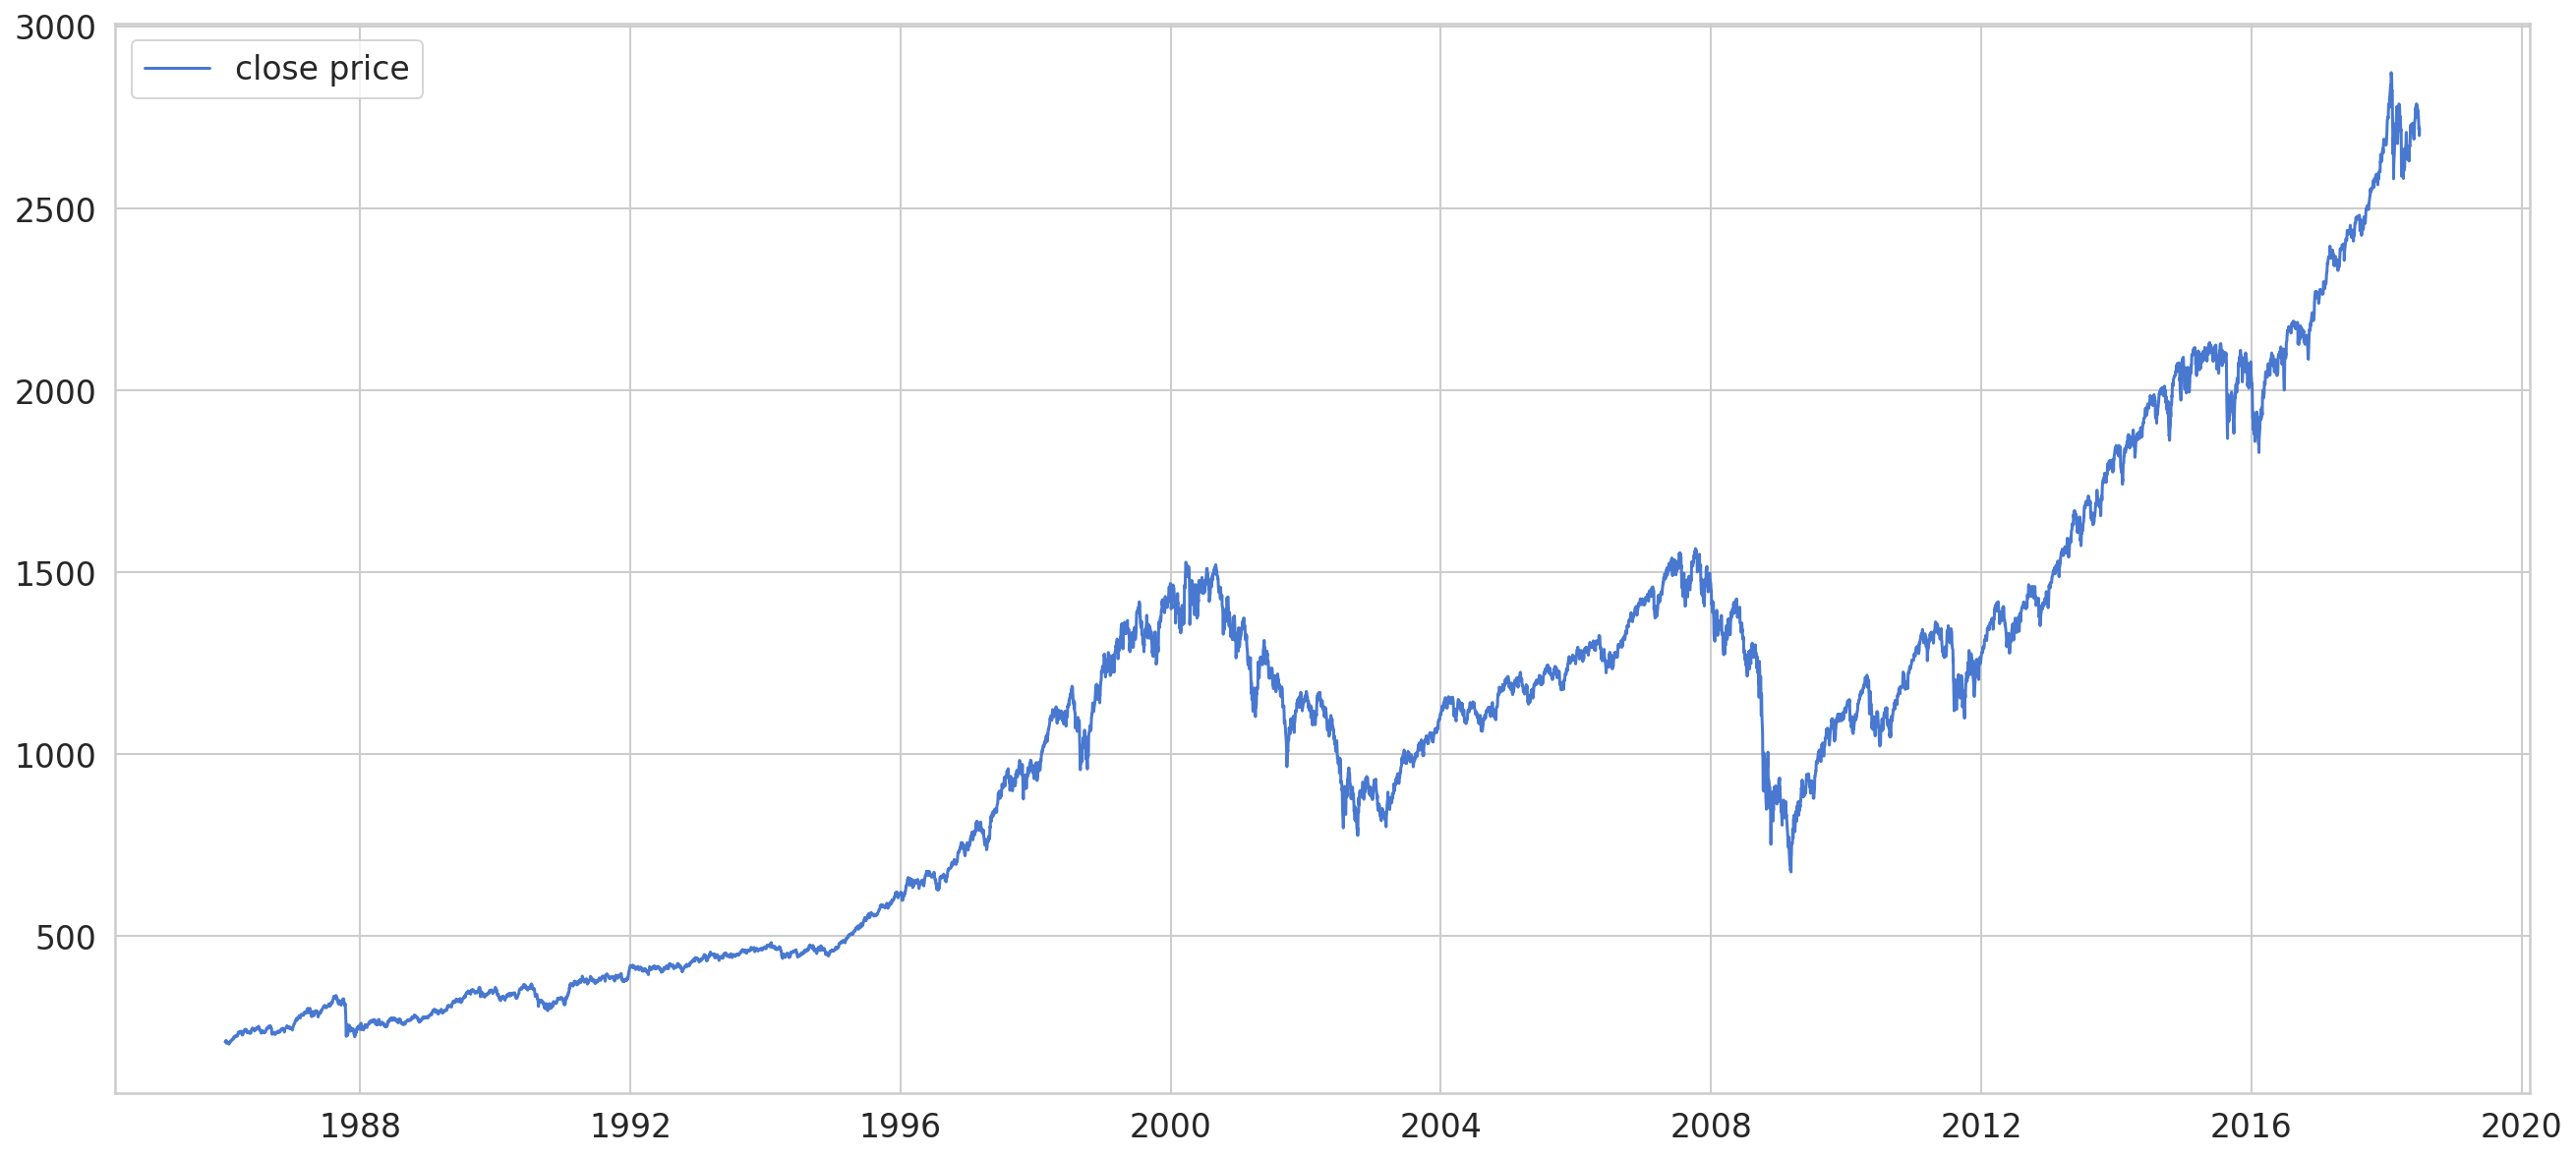

In [35]:
plt.plot(df, label='close price')
plt.legend();

In [36]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size

train, test = df.iloc[:train_size], df.iloc[train_size:]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [38]:
scaler = scaler.fit(train[['close']])

In [39]:
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
train.head()

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169


In [41]:
def create_dataset(X, y, time_steps):
  Xs, Ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i: (i + time_steps)].values
    Xs.append(v)
    Ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(Ys)


In [42]:
TIME_STEPS = 30
X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(7752, 30, 1)


In [43]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])

In [44]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
218/218 [==============================] - 2s 9ms/step - loss: 0.1691 - accuracy: 0.0000e+00 - val_loss: 0.1823 - val_accuracy: 0.0000e+00
Epoch 2/50
218/218 [==============================] - 1s 5ms/step - loss: 0.0935 - accuracy: 0.0000e+00 - val_loss: 0.1604 - val_accuracy: 0.0000e+00
Epoch 3/50
218/218 [==============================] - 1s 6ms/step - loss: 0.0965 - accuracy: 0.0000e+00 - val_loss: 0.1284 - val_accuracy: 0.0000e+00
Epoch 4/50
218/218 [==============================] - 1s 5ms/step - loss: 0.0880 - accuracy: 0.0000e+00 - val_loss: 0.1054 - val_accuracy: 0.0000e+00
Epoch 5/50
218/218 [==============================] - 1s 6ms/step - loss: 0.0918 - accuracy: 0.0000e+00 - val_loss: 0.0654 - val_accuracy: 0.0000e+00
Epoch 6/50
218/218 [==============================] - 1s 6ms/step - loss: 0.1043 - accuracy: 0.0000e+00 - val_loss: 0.0969 - val_accuracy: 0.0000e+00
Epoch 7/50
218/218 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.0000e

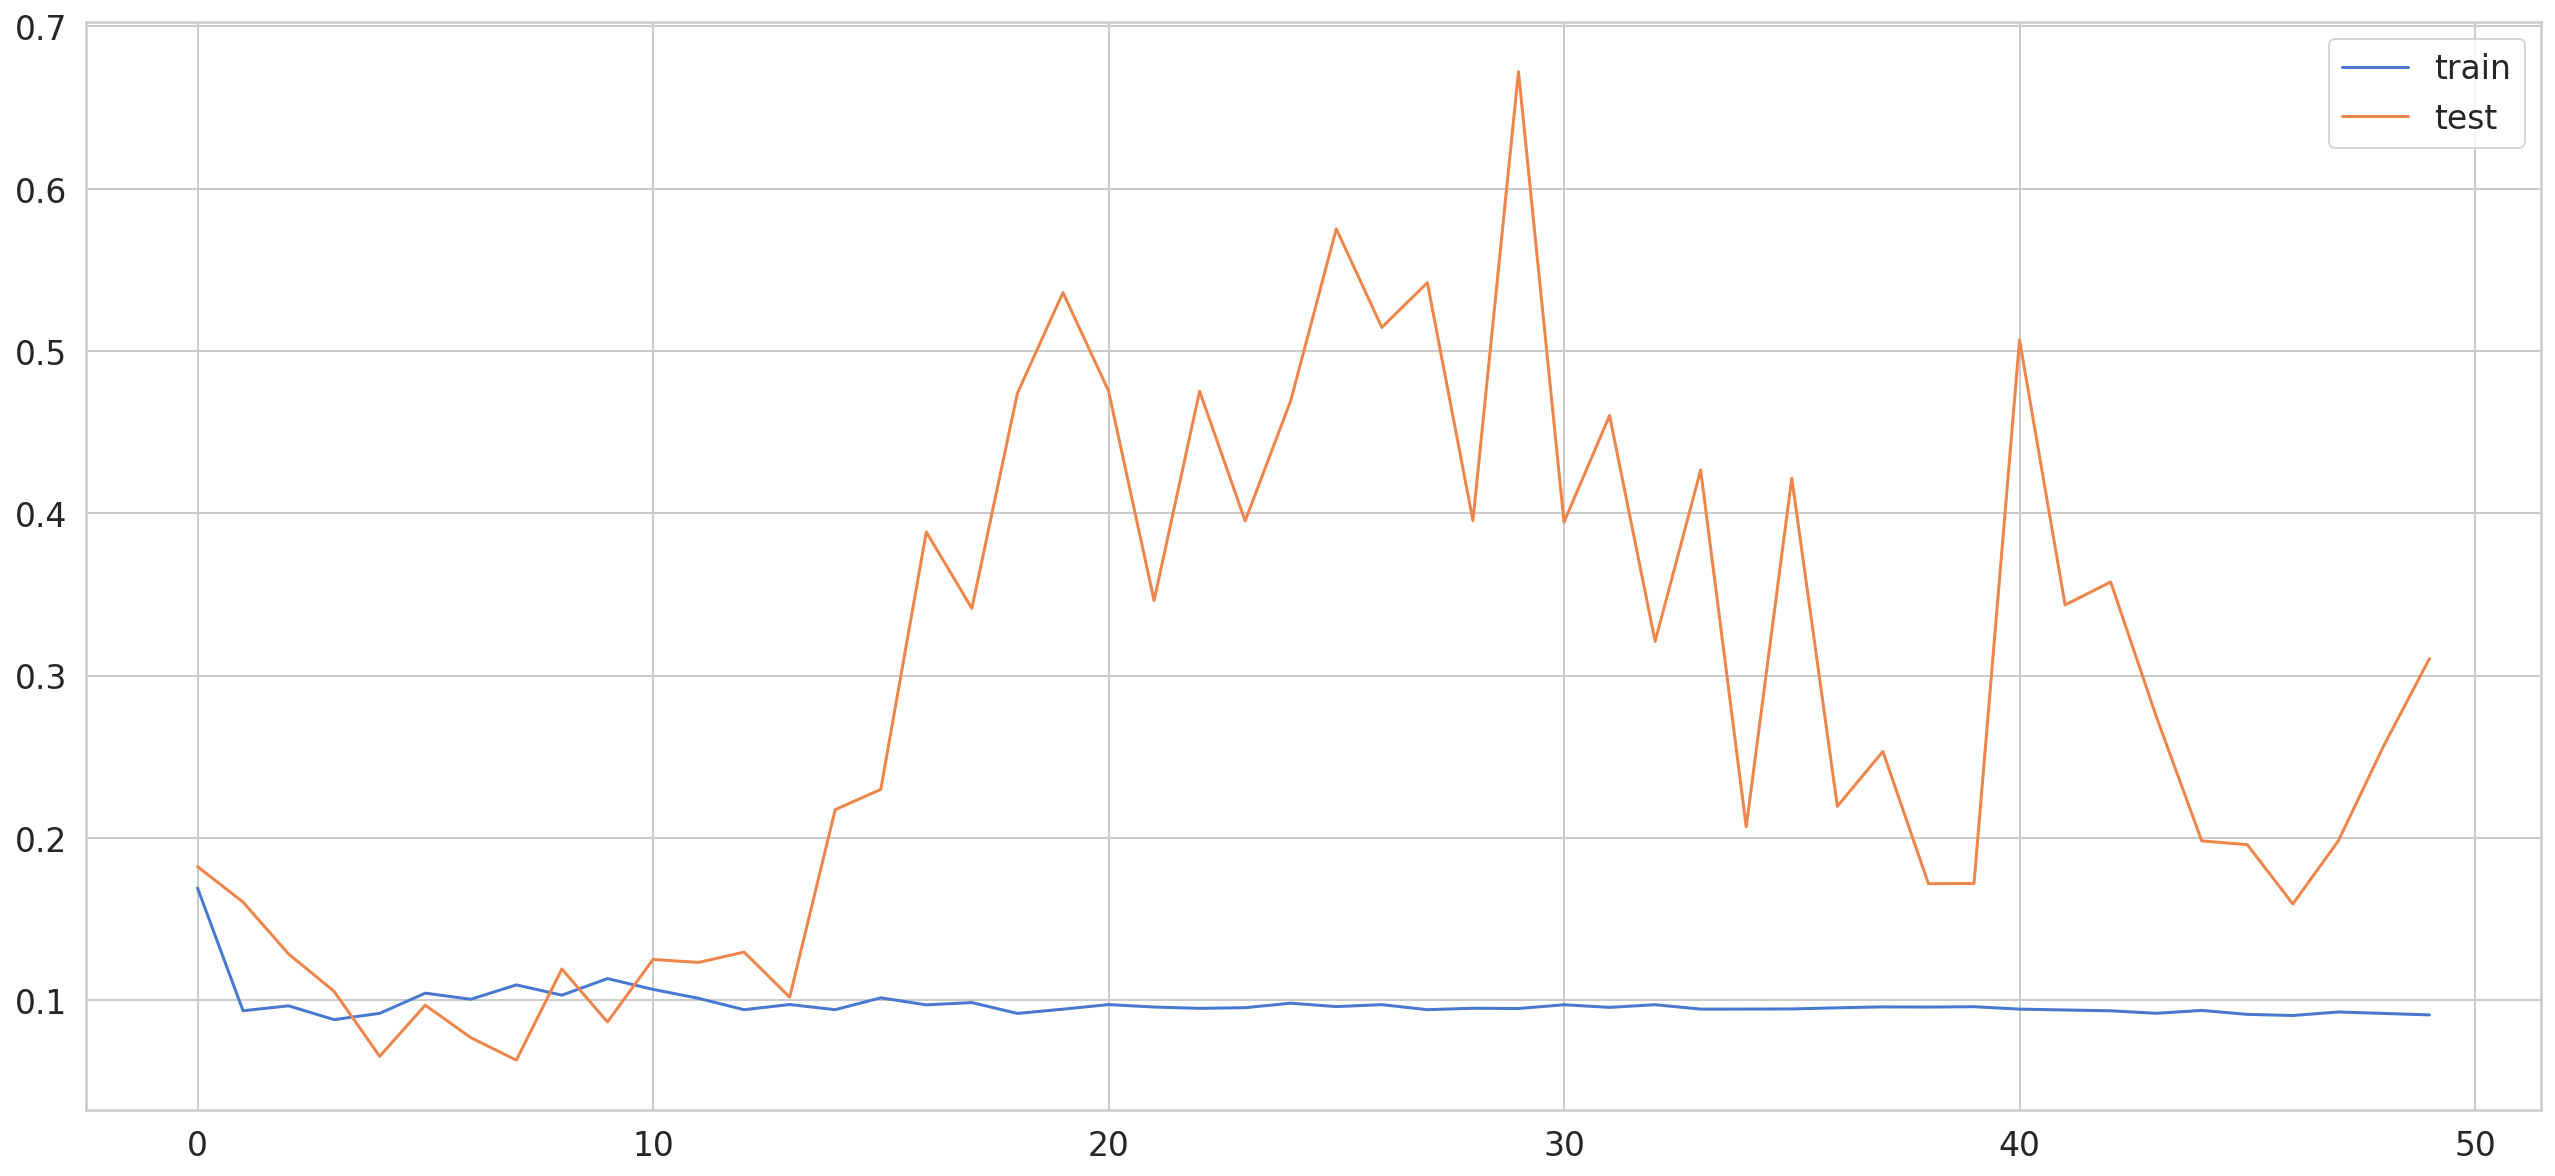

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [46]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

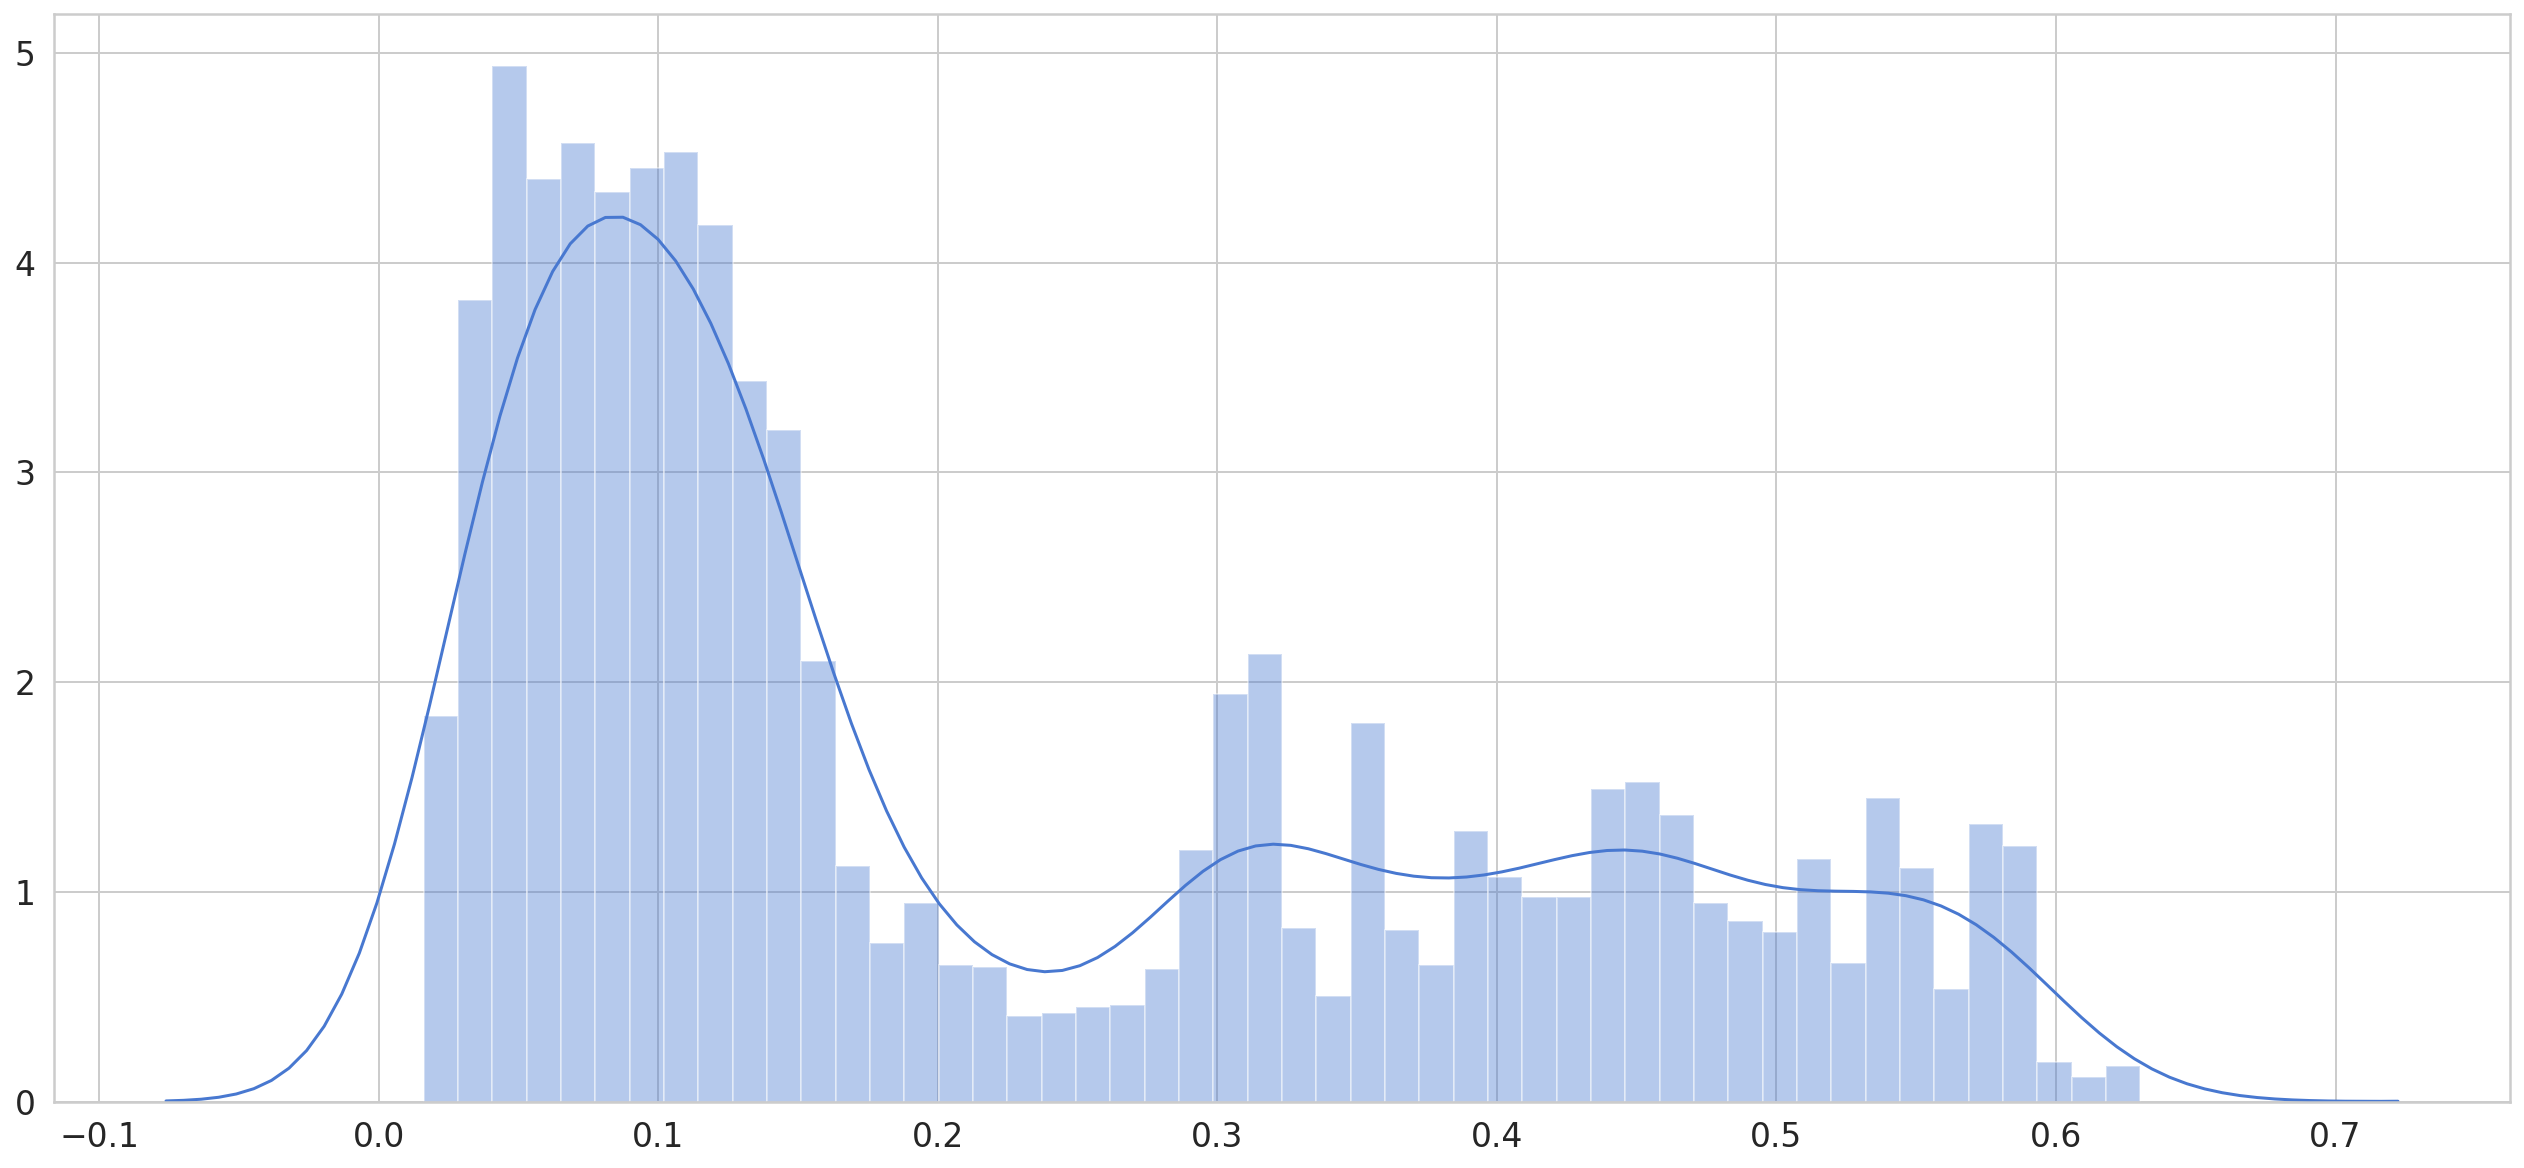

In [47]:
sns.distplot(train_mae_loss, bins=50, kde=True);


In [48]:

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [51]:
THRESHOLD = 0.9

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

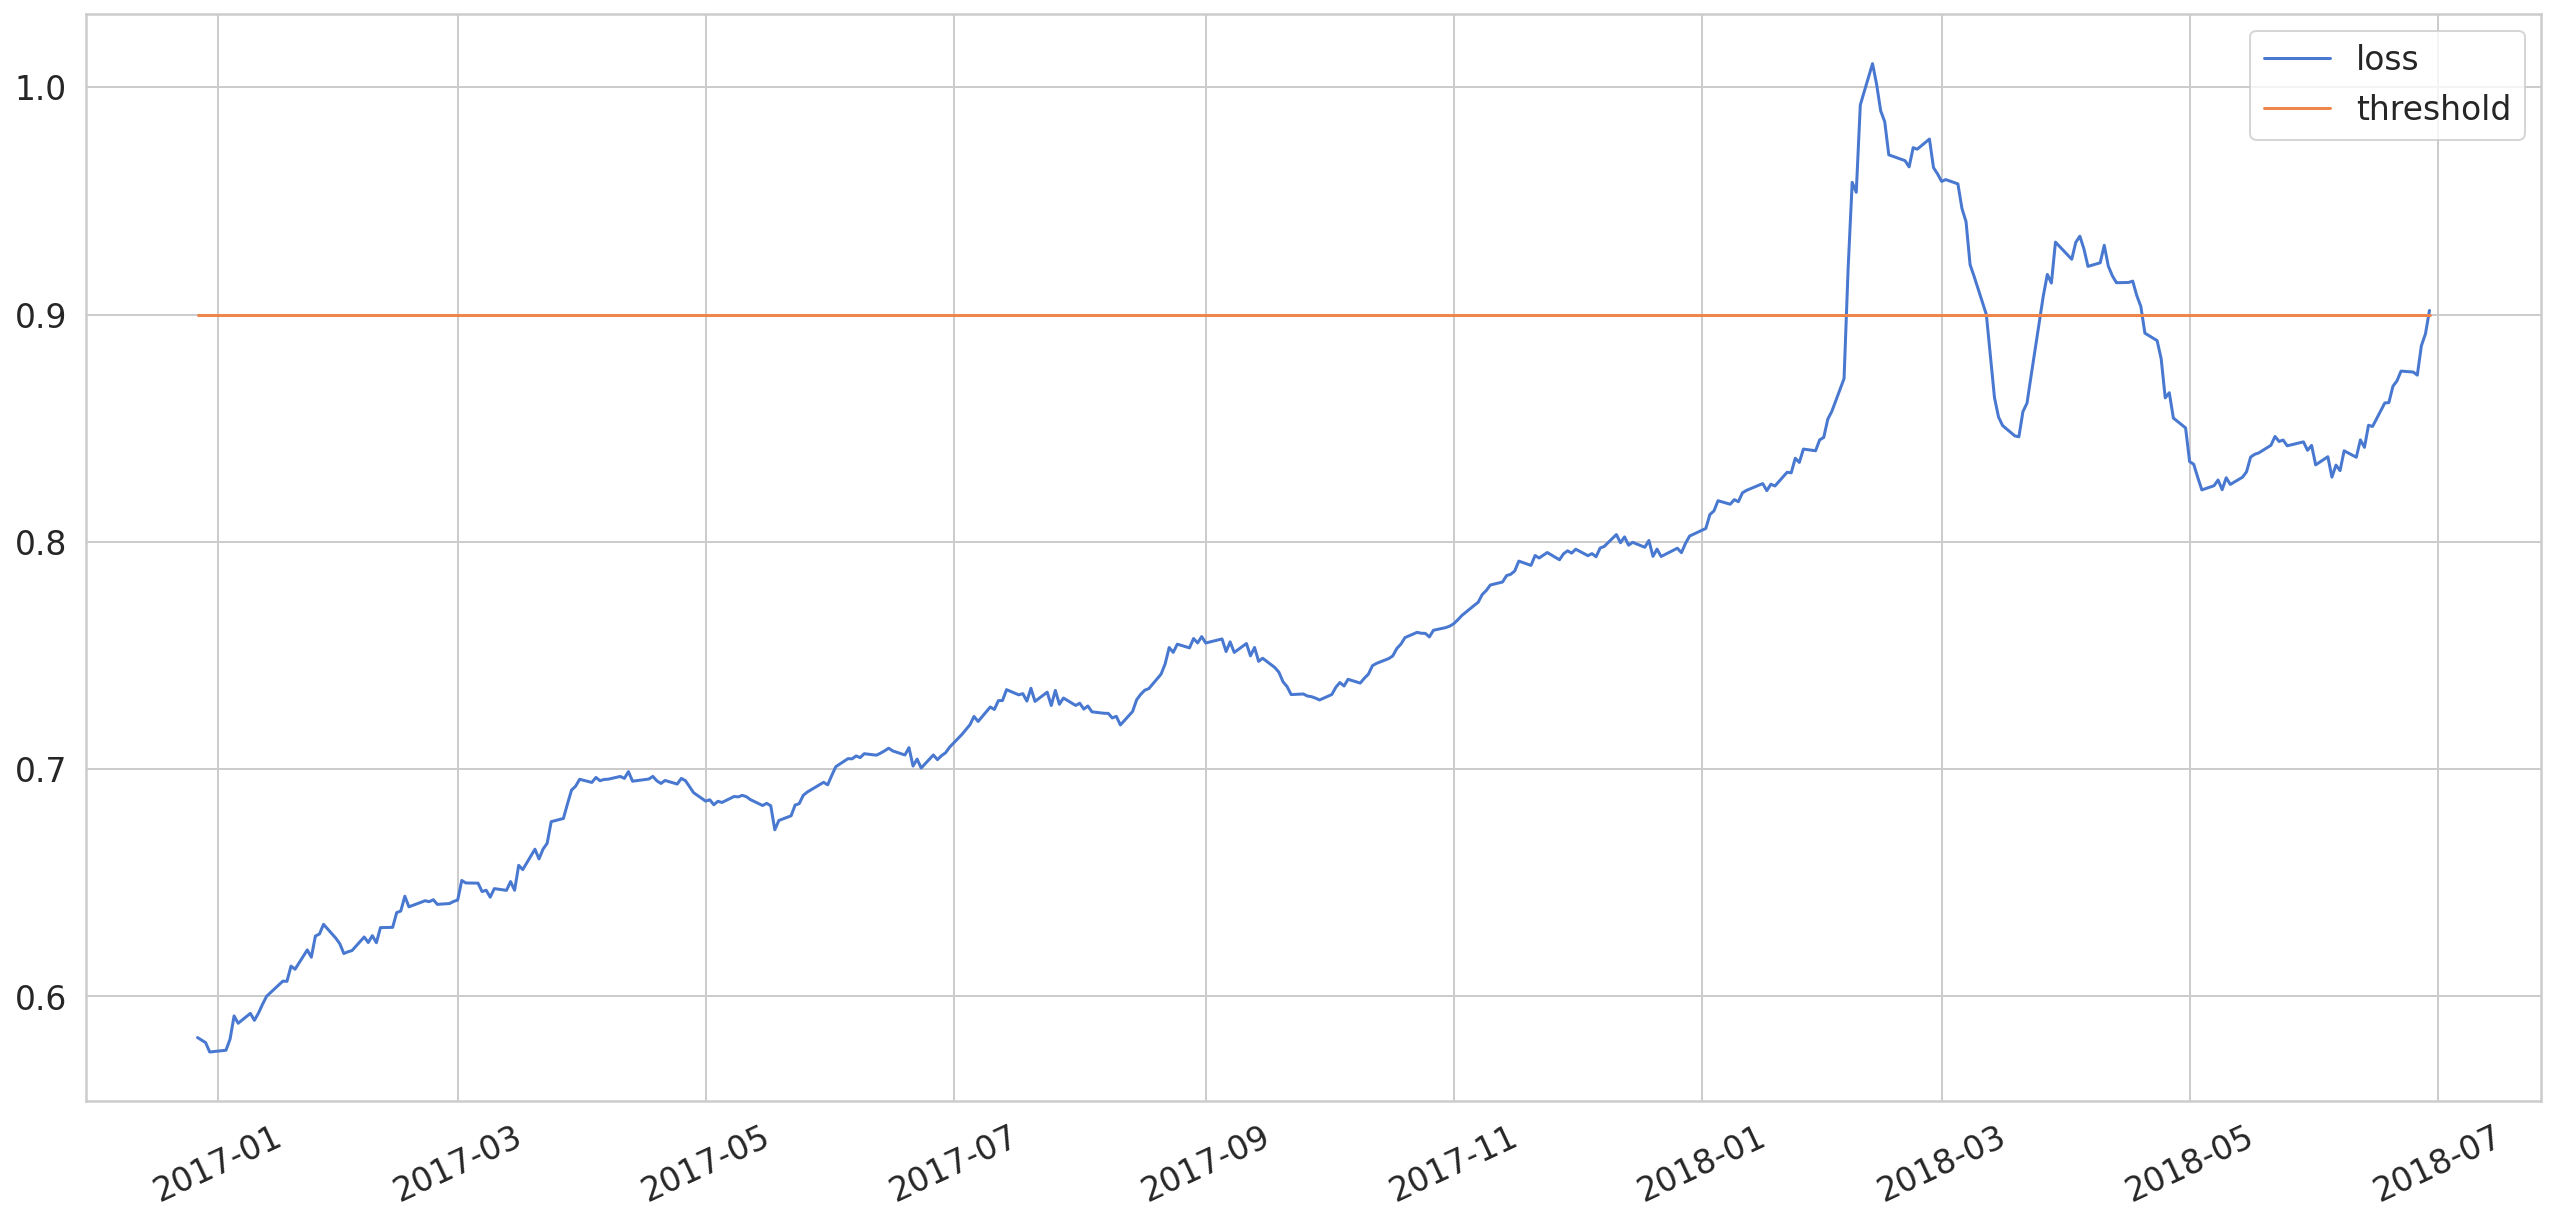

In [52]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [53]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.920255,0.9,True,3.193456
2018-02-07,0.958162,0.9,True,3.168136
2018-02-08,0.953792,0.9,True,2.979068
2018-02-09,0.992271,0.9,True,3.051476
2018-02-12,1.010406,0.9,True,3.119939


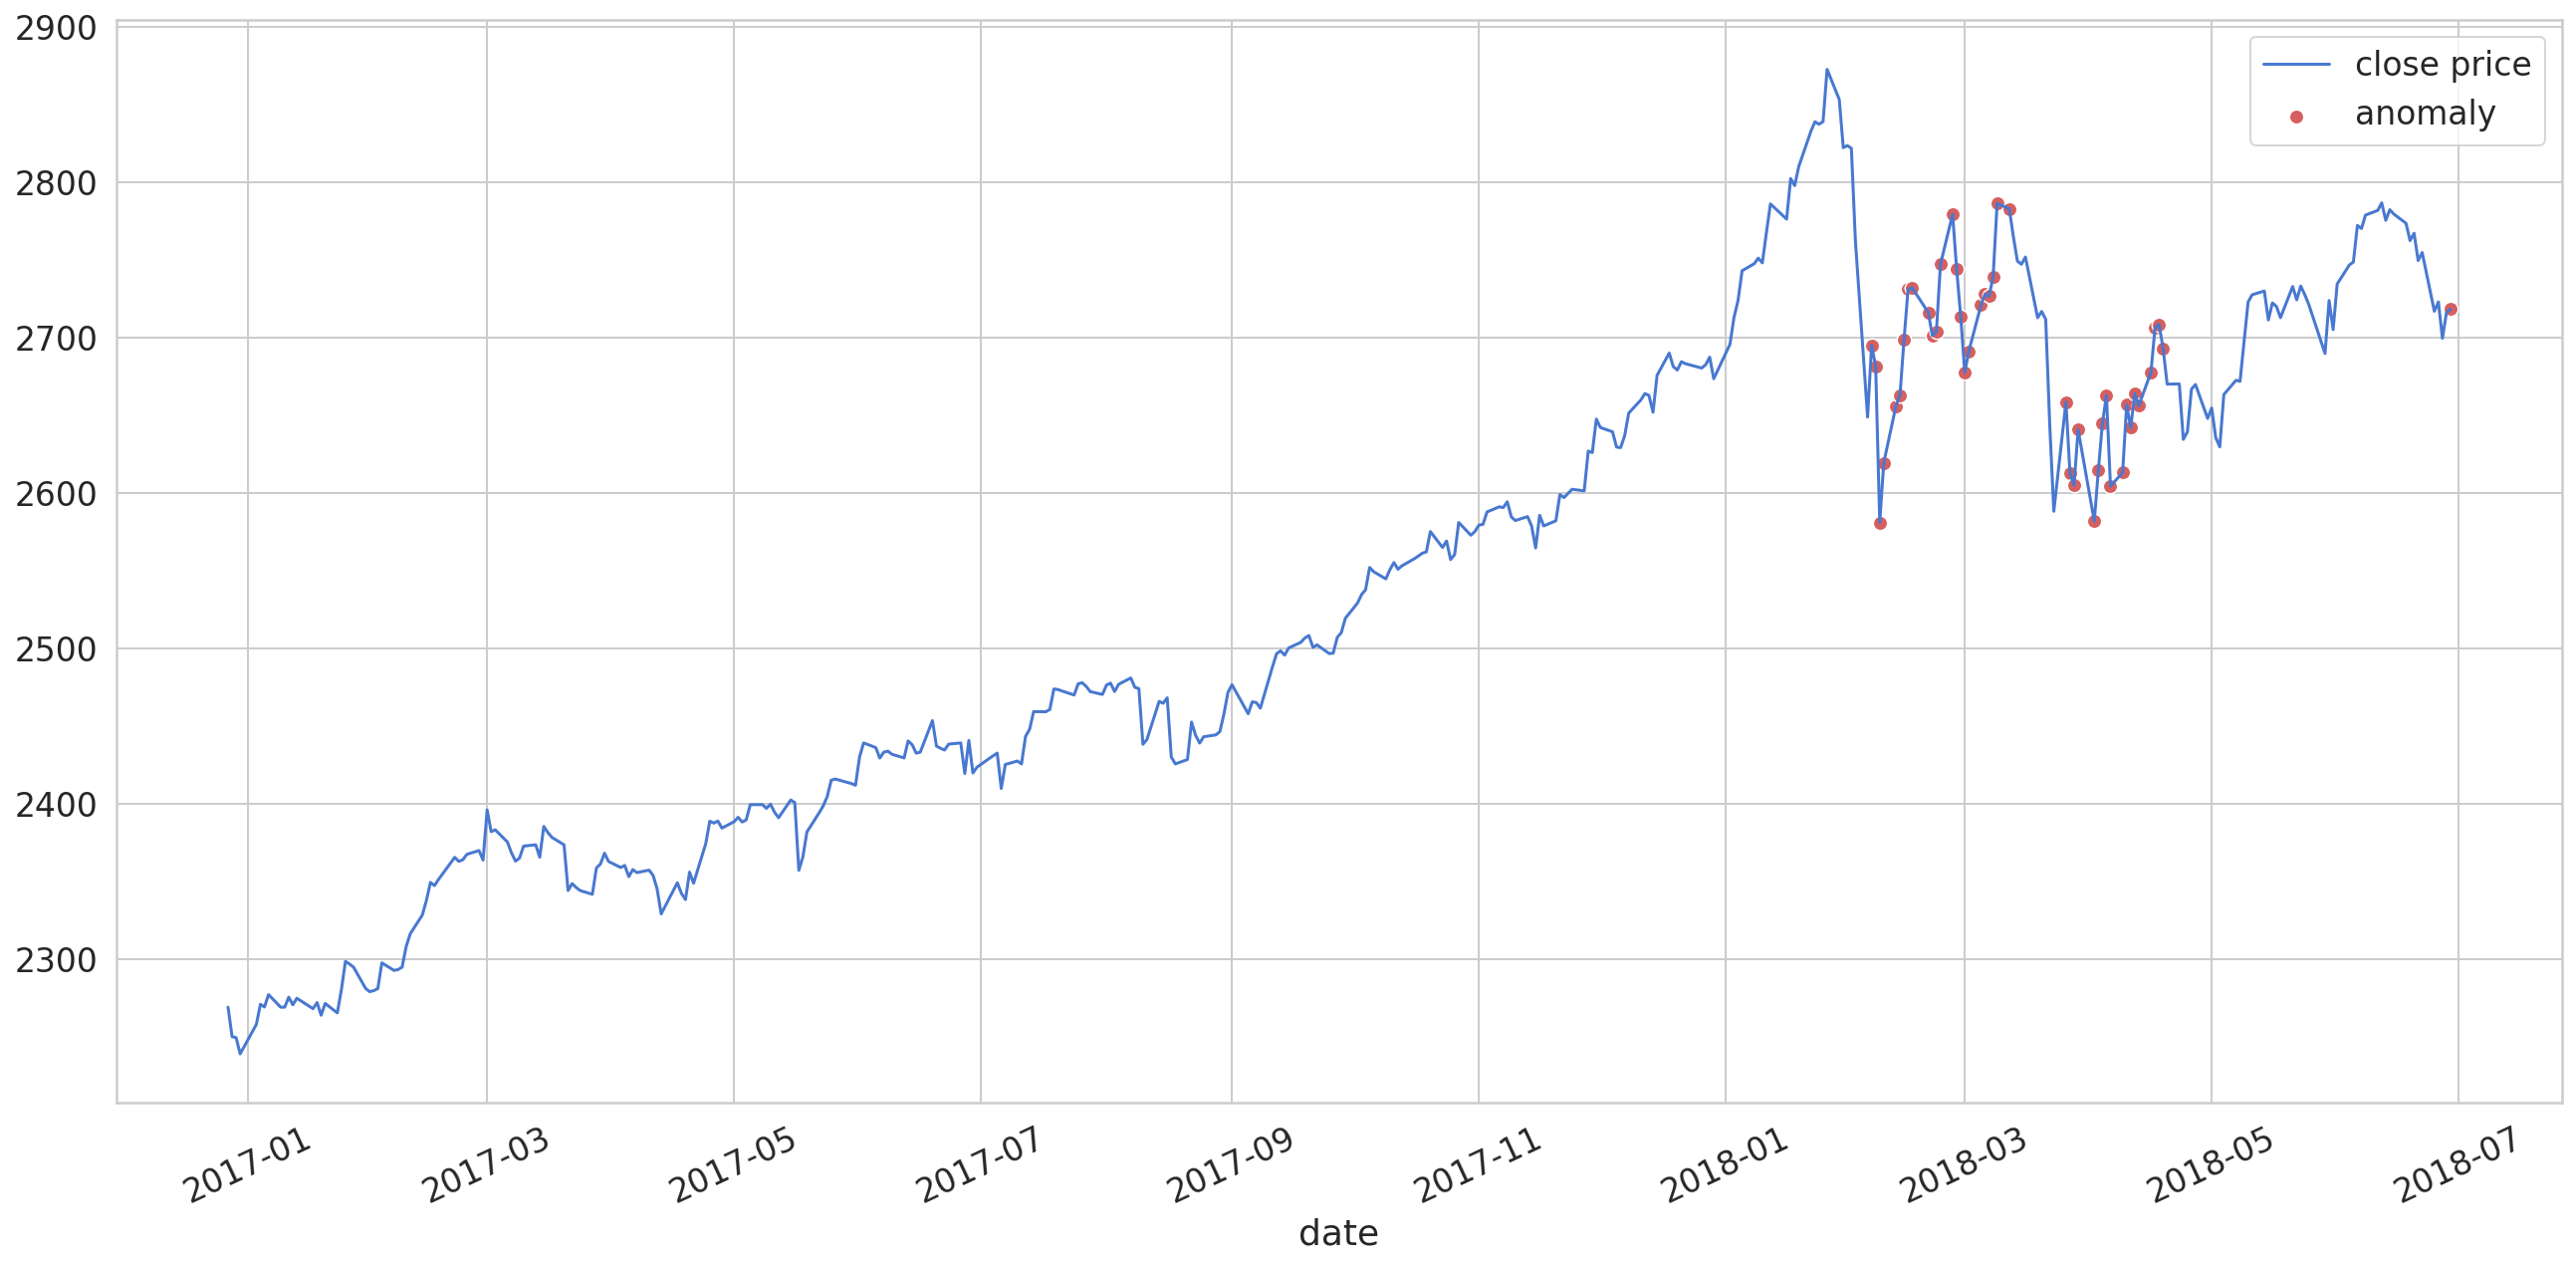

In [54]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();